In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import h5py
import dask.array as da
from dask.distributed import Client, LocalCluster


In [2]:

# Set up a local cluster with multiple workers
cluster = LocalCluster(n_workers=32)
client = Client(cluster)

# Open the HDF5 file
with h5py.File('train_data.h5', 'r') as file:
    # Access the group containing the datasets
    group = file['data']

    # Load the datasets into dask arrays in parallel
    dask_arrays = {}
    for key in group.keys():
        dask_arrays[key] = da.from_array(group[key], chunks='auto')

    # Trigger computation and obtain the NumPy arrays
    numpy_arrays = da.compute(*dask_arrays.values())


# Close the Dask client and cluster
client.close()
cluster.close()

2023-06-28 20:34:02,755 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-bbz_u397', purging
2023-06-28 20:34:02,755 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-br7ok13_', purging
2023-06-28 20:34:02,755 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-y5z80vq0', purging
2023-06-28 20:34:02,756 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-u60b65e2', purging
2023-06-28 20:35:26,376 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/tng4/users/skayasth/envs/pt/lib/python3.9/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exceptio

In [3]:
numpy_arrays[0].shape

(8000, 512, 512, 3)

In [19]:
numpy_arrays = list(numpy_arrays)

In [21]:
numpy_arrays[0].shape

(8000, 512, 512, 3)

In [3]:
import glob
import os
import mat73
data_path = "/tng4/users/skayasth/Yearly/2023/Jan/TCEQ/Data_for_PCNN"
File_List = sorted(glob.glob(os.path.join(
    data_path, 'Mask_Mean*.mat')))
MODIS_AOD_file = mat73.loadmat(os.path.join(
    data_path, "Regridded_MODIS_AOD_4km_Mid_2017_2022_CONUS.mat"))
PUS4k = mat73.loadmat(os.path.join(
    data_path, "Regridded_PUS_4km_2016_CONUS.mat"))

In [4]:
file= mat73.loadmat(File_List[0])

obs = file[f'Mean_PM_STNs_{2018}']
obs = np.nan_to_num(obs, nan=np.nan).astype(np.float32)
obs = np.einsum('ijk->kij', obs)
obs = obs / 450.0
obs = np.nan_to_num(obs, nan=1).astype(np.float32)
Mask = file[f"Mask_PM_STNs_{2018}"]

In [5]:
import pickle
with open("/tng4/users/skayasth/Yearly/2023/June/TCEQ_Final/Phase1/runs/May_300/maxes.pkl", 'rb') as f:
    arr_loaded = pickle.load(f)


_, modis_max, pus_max = arr_loaded

In [6]:
one_obs = obs[0]
one_mask = Mask[:,:,0]
one_modis = MODIS_AOD_file['MODIS_AOD'][:,:,10] / modis_max
one_pus = PUS4k['PUS_CONUS'] / pus_max

In [7]:
ne_data = np.array([one_obs, one_modis, one_pus])
ne_data = np.expand_dims(ne_data, axis=0)
ne_mask = np.array([one_mask, np.ones_like(one_mask), np.ones_like(one_mask)])
ne_mask = np.expand_dims(ne_mask, axis=0)


In [12]:
model = torch.load('checkpoints/G_model.pth')
model = model
model.eval()

DataParallel(
  (module): Generator(
    (start): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(6, 48, kernel_size=(7, 7), stride=(1, 1))
      (2): InstanceNorm2d(48, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): GELU()
    )
    (trane256): Sequential(
      (0): TransformerEncoder(
        (attn): mGAttn(
          (query): Sequential(
            (0): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
            (1): GELU()
            (2): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
            (3): Softplus(beta=1, threshold=20)
          )
          (key): Sequential(
            (0): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
            (1): GELU()
            (2): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
            (3): Softplus(beta=1, threshold=20)
          )
          (value): Sequential(
            (0): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
            (1): GELU()
          )
    

In [15]:
ne_data.shape

(1, 3, 778, 1456)

In [ ]:

test_img = torch.from_numpy(ne_data[:,:,:512,:512]).float().cuda()
test_mask = torch.from_numpy(ne_mask[:,:,:512,:512]).float().cuda()
inp_img = test_img * test_mask
out = model.forward(inp_img, test_mask )
out_2 = out  * (1 - test_mask) + inp_img

In [16]:

test_img = torch.from_numpy(ne_data[:,:,778-512:,1456-512:]).float().cuda()
test_mask = torch.from_numpy(ne_mask[:,:,778-512:,1456-512:]).float().cuda()
inp_img = test_img * test_mask
out = model.forward(inp_img, test_mask )
out_2 = out  * (1 - test_mask) + inp_img

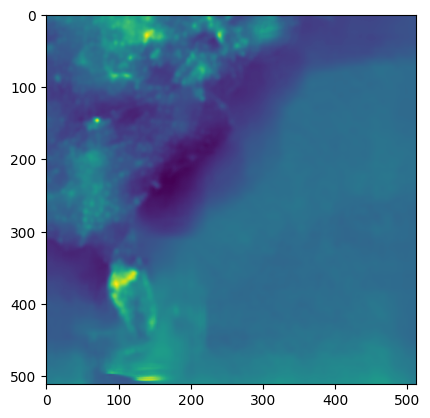

In [17]:
plt.imshow(out[0][0].detach().cpu().numpy())

In [13]:
test_img = torch.from_numpy(ne_data[:,:,:,:]).float().cuda()
test_mask = torch.from_numpy(ne_mask[:,:,:,]).float().cuda()
inp_img = test_img * test_mask
out = model.forward(inp_img, test_mask )
out_22 = out  * (1 - test_mask) + inp_img

RuntimeError: Sizes of tensors must match except in dimension 2. Got 68 and 67 (The offending index is 0)

In [ ]:
plt.imshow(out_2[0][0].detach().numpy())

In [ ]:
import scipy.io as sio
DP_PCNN_PM = "/tng4/users/skayasth/Yearly/2023/Apr/PCNN_TCEQ/runs/May_300/outputs/"
PCNN_PM_All_Data = sio.loadmat(DP_PCNN_PM + f"PCNN_Output_{2018}.mat") 

In [ ]:
PCNN_PM = PCNN_PM_All_Data["Station_Output"][:]

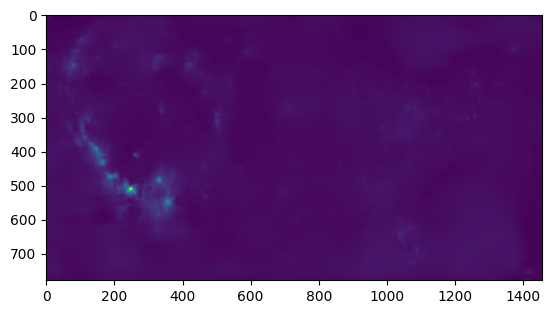

In [ ]:
plt.imshow(PCNN_PM[0])

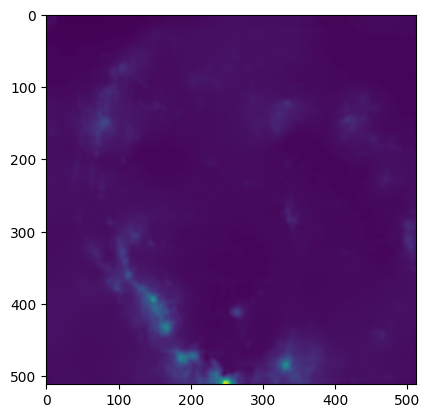

In [ ]:
plt.imshow(PCNN_PM[0][:512,:512])

In [ ]:
plt.imshow(out[0][0].detach().cpu().numpy())

In [ ]:
PCNN_PM.shape

(365, 778, 1456)

In [ ]:
l_t 
r_t 

(365, 778, 1456)

In [ ]:
512*1.5

768.0

In [ ]:
day_in_padded = np.zeros((896, 1536, 3))
day_in_padded[59:837, 40:1496, :] = PCNN_PM[0]
mask_in_padded = np.ones((896, 1536, 3))
mask_in_padded[59:837, 40:1496, :] = input_mask

1536

In [ ]:
# Save dictionary to a file
with open('Station_dict.pkl', 'rb') as file:
    Station_dict = pickle.load(file)
    
with open('Mask_dict.pkl', 'rb') as file:
    Mask_dict = pickle.load(file)

In [ ]:
import h5py

In [ ]:
data_2018 = {'data': Station_dict['2018'], 'mask': Mask_dict['2018']}

In [ ]:
with h5py.File('data_2018.h5', 'w') as file:
    # Create groups in the HDF5 file
    group = file.create_group("data")

    # Save each dictionary key-value pair as a dataset
    for key, value in data_2018.items():
        group.create_dataset(key, data=value, compression="gzip")


In [ ]:
# Define the desired padded dimensions
original_array = PCNN_PM

padded_height, padded_width = 1024, 1536


# Get the original array shape
original_height, original_width, original_channels = original_array.shape

# Calculate the required amount of padding
pad_height = padded_height - original_height
pad_width = padded_width - original_width

# Calculate the padding sizes for each dimension
top_padding = pad_height // 2
bottom_padding = pad_height - top_padding
left_padding = pad_width // 2
right_padding = pad_width - left_padding


# Perform the zero-padding
padded_array = np.pad(original_array, ((top_padding, bottom_padding), (left_padding, right_padding), (0, 0)), mode='constant')

unpadded_array = padded_array[top_padding:top_padding+original_height, left_padding:left_padding+original_width, :]


In [ ]:
with h5py.File('data_2018.h5', 'r') as file:
    # Access the group containing your data
    group = file['data']

    # Initialize an empty dictionary to store the loaded data
    loaded_data = {}

    # Load each dataset within the group
    for key in group.keys():
        loaded_data[key] = group[key][()]


In [ ]:
loaded_data.keys()

dict_keys(['data', 'mask'])

In [ ]:
loaded_data['mask'].shape

(365, 778, 1456, 3)

In [ ]:
padded_array.shape

NameError: name 'padded_array' is not defined